In [20]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
color_palettes = ['Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2','Set3',
                  'cubehelix','gnuplot', 'tab10']

sns.set_palette("tab10")
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

# Load BioBank Components

In [3]:
biobank_data, biobank_index, med_code_mapping = data_tools.load_all_biobank_components()

Importing BioBank Index and Data:
Missing 0 biobank index names
UK BioBank Data Loaded.
Size: 9999 rows x 2781 columns
Elapsed time: 4.5391 seconds


Mapping ICD10 Codes:   0%|          | 0/2018 [00:00<?, ? feature/s]

# Term Searches / Tree Examples

In [4]:
med_code_mapping.build_tree(code_format="1001");

ethnic_background_2.0
├── Asian or Asian British (3)
│   ├── Any other Asian background (3004)
│   ├── Bangladeshi (3003)
│   ├── Indian (3001)
│   └── Pakistani (3002)
├── Black or Black British (4)
│   ├── African (4002)
│   ├── Any other Black background (4003)
│   └── Caribbean (4001)
├── Chinese (5)
├── Do not know (-1)
├── Mixed (2)
│   ├── Any other mixed background (2004)
│   ├── White and Asian (2003)
│   ├── White and Black African (2002)
│   └── White and Black Caribbean (2001)
├── Other ethnic group (6)
├── Prefer not to answer (-3)
└── White (1)
    ├── Any other white background (1003)
    ├── British (1001)
    └── Irish (1002)



In [5]:
med_code_mapping.search_codes("mononucleosis").head()

,coding,meaning,code_format,feature
0,0,No,7,asthma_dx
362,1567,infectious mononucleosis / glandular fever / e...,6,illness_code
0,0,No,100267,pregnant_current
0,0,No,100264,phasing_use_chr_1_22
2,9,No,100258,birth_weigh_known


In [6]:
index_tools.term_search(biobank_index, "cancer")

['cancer_first_year_age',
 'illness_first_year_age',
 'n_cancers',
 'n_non_cancer_illnesses',
 'cancer_dx',
 'cancer_code',
 'illness_code',
 'cancer_dx_year_interpolated',
 'cancer_dx_age_interpolated',
 'illness_dx_year_interpolated',
 'illness_dx_age_interpolated',
 'cancer_dx_recording_time_method',
 'illness_dx_recording_time_method',
 'cancer_dx_date',
 'cancer_type_ICD10',
 'cancer_dx_age',
 'cancer_occurences',
 'cancer_tumor_histology',
 'cancer_tumor_behavior',
 'cancer_type_ICD9',
 'cancer_report_format']

# Feature Exploration

In [7]:
# feature_data = {"feature": [], "feature_samples": [], "n_unique": []}

# for column in tqdm(biobank_data.columns, desc="Analyzing features", unit=" feature"):
#     unique_features = biobank_data[column].unique()
#     feature_data["feature_samples"].append(np.random.choice(unique_features, min(5, len(unique_features))))
#     feature_data["feature"].append(column)
#     feature_data["n_unique"].append(len(unique_features))
    
# feature_data = pd.DataFrame(feature_data)

# Feature Index EDA

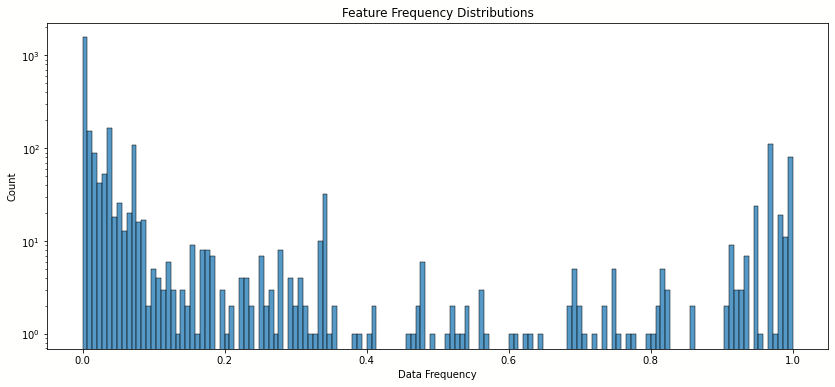

In [8]:
fig, ax = plt.subplots(figsize=(14, 6), facecolor="#fffffe")
sns.histplot(biobank_index["frequency"], ax=ax)
ax.set_yscale("log")
add_plt_labels(ax, "Data Frequency", "Count", "Feature Frequency Distributions")
plt.show()
fig.tight_layout()
fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("feature_frequency_distribution.png"), facecolor="#fffffe")

# actual EDA

In [9]:
cancer_biobank = biobank_data.loc[~biobank_data["cancer_code"].isna()]

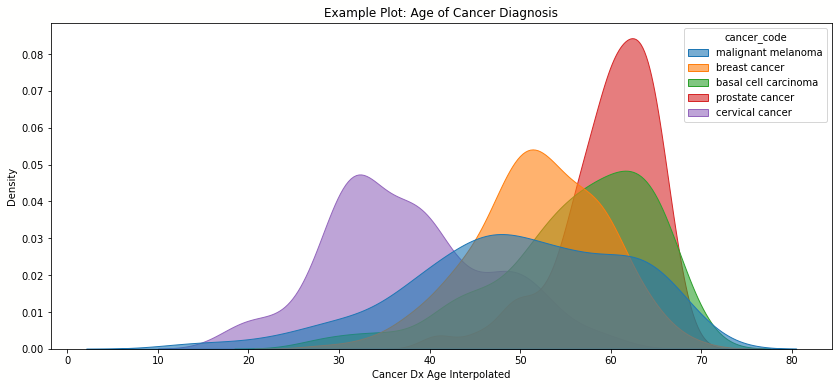

In [14]:
cancer_codes, counts = np.unique(cancer_biobank["cancer_code"], return_counts=True)

common_cancer_codes = cancer_codes[np.argsort(counts,)[-5:]]
common_cancer_biobank = cancer_biobank.loc[cancer_biobank["cancer_code"].isin(common_cancer_codes)]

fig, ax = plt.subplots(figsize=(14, 6), facecolor="#fffffe")
sns.kdeplot(data=common_cancer_biobank, x="cancer_dx_age_interpolated", hue="cancer_code", ax=ax,
            cumulative=False, shade=True, common_norm=False, bw_method=.35, alpha=.6)
ax.set_title("Example Plot: Age of Cancer Diagnosis")
add_plt_labels(ax, "cancer_dx_age_interpolated", "Density")
fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("cancer_dx_age.png"), facecolor="#fffffe")

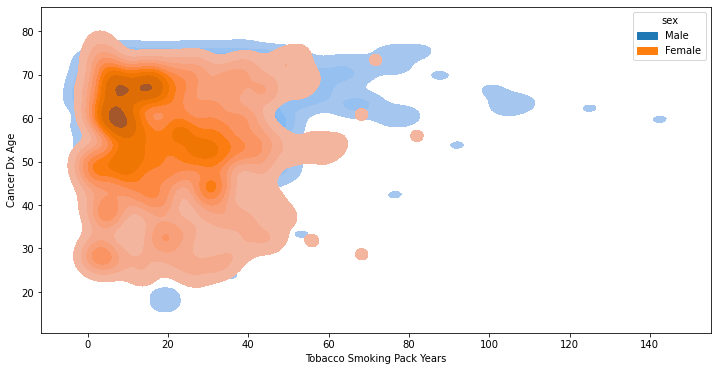

In [19]:
y, x = "cancer_dx_age", "tobacco_smoking_pack_years"

fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=biobank_data, x=x, y=y, hue="sex", ax=ax, fill=True, bw_method=.2)
add_plt_labels(ax, x, y)

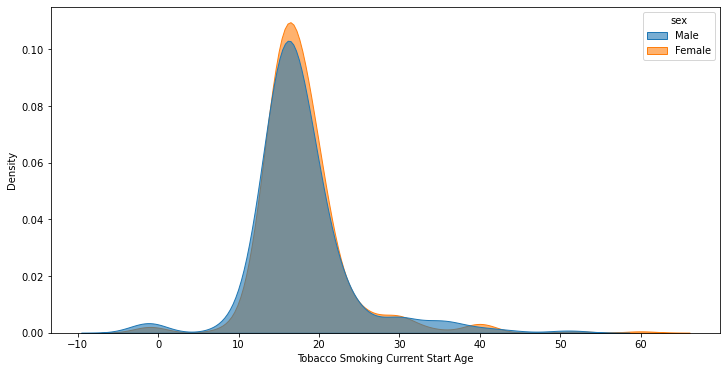

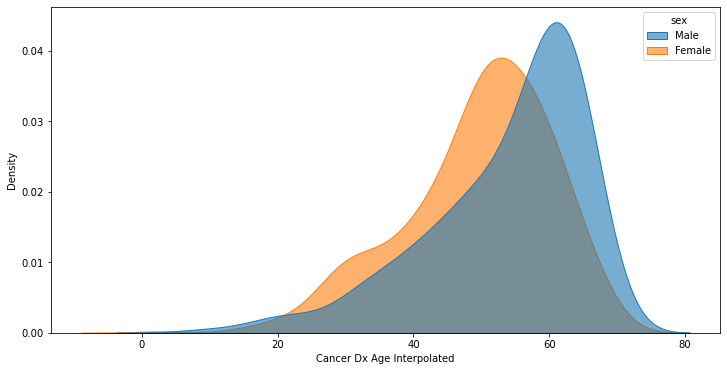

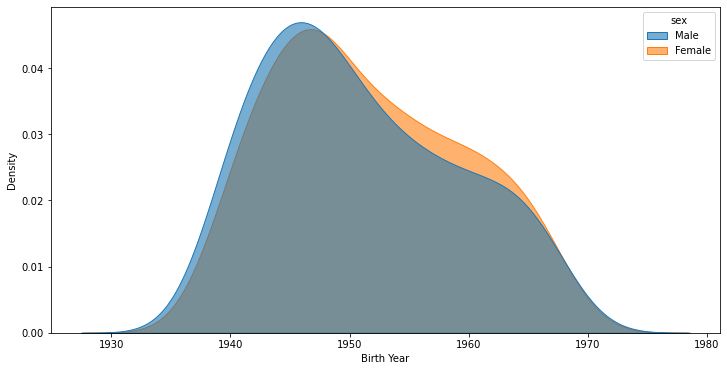

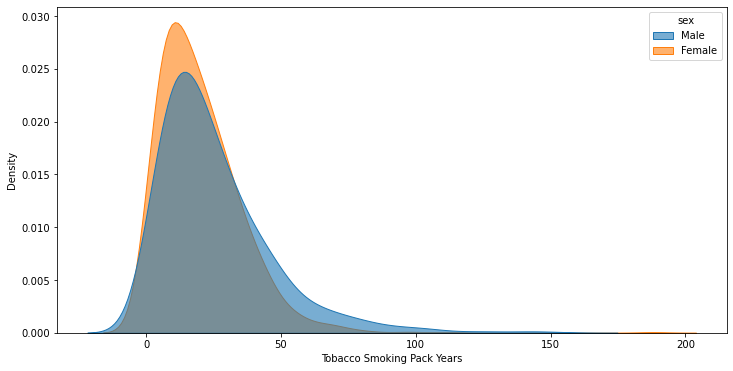

In [12]:
x_s = ["tobacco_smoking_current_start_age", "cancer_dx_age_interpolated",
          "birth_year", "tobacco_smoking_pack_years"]
for x in x_s:
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.kdeplot(data=biobank_data, x=x, hue="sex", ax=ax, shade=True, 
                alpha=.6, bw_method=.35, common_norm=False)
    add_plt_labels(ax, x, y="Density")